Dataset split completed:
Training samples: 7220
Validation samples: 1805
CLAHE preprocessing completed for train and validation datasets.
Found 7220 images belonging to 5 classes.
Found 1805 images belonging to 5 classes.
Preprocessing and data generators are ready!
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)     

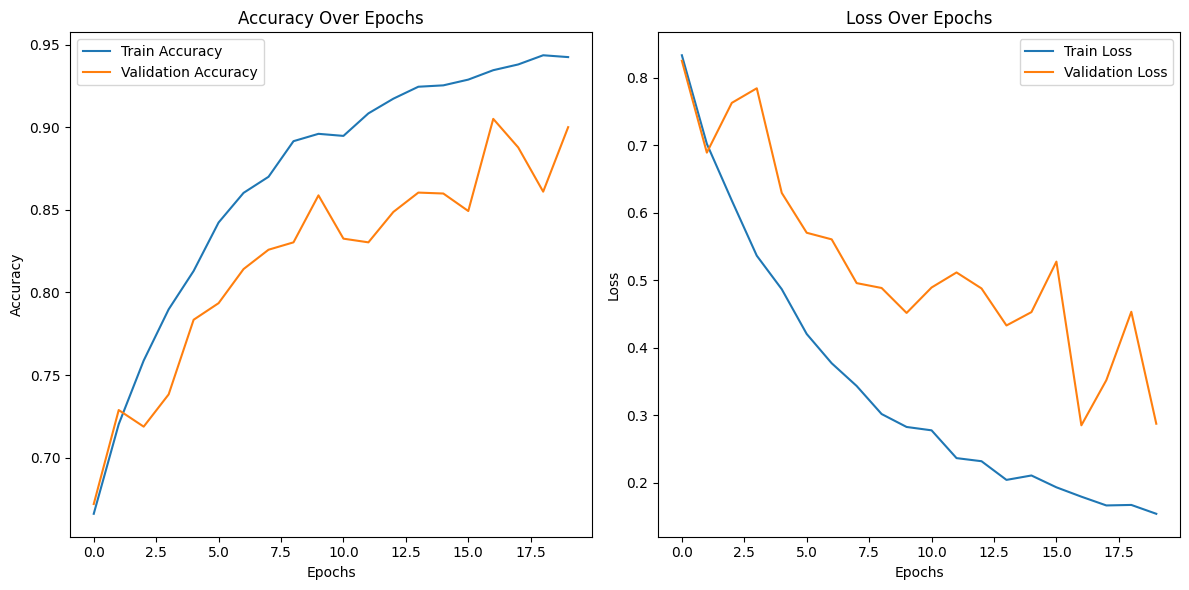

In [1]:
import os
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from tensorflow.keras.layers import Dropout

# ----- Dataset Preparation -----

# Paths for dataset
balanced_dir = r"C:\Users\Mubashir\Desktop\DIABETIC\dataset\balanced"  # Path to your dataset
output_dir = r"C:\Users\Mubashir\Desktop\DIABETIC\F"  # Output directory for train/val splits
os.makedirs(output_dir, exist_ok=True)

# Create train and validation directories
splits = ['train', 'val']
for split in splits:
    for label in os.listdir(balanced_dir):
        os.makedirs(os.path.join(output_dir, split, label), exist_ok=True)

# Gather file paths and labels
file_paths = []
labels = []
for label in os.listdir(balanced_dir):
    class_dir = os.path.join(balanced_dir, label)
    for file in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, file))
        labels.append(label)

# Create DataFrame for splitting
df = pd.DataFrame({'file_path': file_paths, 'label': labels})

# Split the data: 80% train, 20% validation
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Copy files into respective directories
def copy_files(df, split):
    for _, row in df.iterrows():
        label_dir = os.path.join(output_dir, split, row['label'])
        shutil.copy(row['file_path'], label_dir)

copy_files(train_df, 'train')
copy_files(val_df, 'val')

print("Dataset split completed:")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# ----- Preprocessing with CLAHE -----
def apply_clahe(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    img = cv2.merge((l, a, b))
    img = cv2.cvtColor(img, cv2.COLOR_LAB2BGR)
    return img

# Save preprocessed images back to directories
def preprocess_and_save_images(data_dir):
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            preprocessed_img = apply_clahe(img_path)
            cv2.imwrite(img_path, preprocessed_img)

preprocess_and_save_images(os.path.join(output_dir, 'train'))
preprocess_and_save_images(os.path.join(output_dir, 'val'))

print("CLAHE preprocessing completed for train and validation datasets.")

# ----- Preprocessing for Model Input -----
target_size = (224, 224)  # For DenseNet-169
batch_size = 32

# Create Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True,brightness_range=[0.8, 1.2])

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Paths for the splits
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')

train_generator = train_datagen.flow_from_directory(train_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical')

print("Preprocessing and data generators are ready!")


# Load the pre-trained DenseNet-169 model (excluding top layers)
base_model = tf.keras.applications.DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce dimensionality
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.4)(x) #Add dropout with 40% dropout rate
x = Dense(5, activation='softmax')(x)  # Output layer with 5 classes

# Build the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# EarlyStopping to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model (initial training with frozen layers)
history = model.fit(
    train_generator,
    epochs=20,  # Train for 20 epochs
    validation_data=val_generator,
    callbacks=[early_stopping],
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)

# Save the trained model
model.save("diabetic_retinopathy_model169_initial_20epochs.h5")
print("Initial model training complete and saved.")

# Unfreeze more layers for fine-tuning
base_model.trainable = True

# Unfreeze the last 50 layers of DenseNet-169 (for example)
for layer in base_model.layers[:-100]:  # Unfreeze the last 50 layers
    layer.trainable = False

# Recompile with a lower learning rate for fine-tuning
new_learning_rate = 0.0001  # Lower learning rate for fine-tuning
optimizer = Adam(learning_rate=new_learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train again with the new settings (fine-tuning)
history_finetune = model.fit(
    train_generator,
    epochs=20,  # Fine-tune for 20 epochs
    validation_data=val_generator,
    callbacks=[early_stopping],
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)

# Save the fine-tuned model
model.save("diabetic_retinopathy_model169_finetuned_20epochs.h5")
print("Model re-trained with adjusted learning rate and fine-tuning layers.")

# ----- Evaluation and Metrics -----

# Plot loss and accuracy
def plot_metrics(history):
    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(history_finetune)

1/1 [==============================] - 3s 3s/step


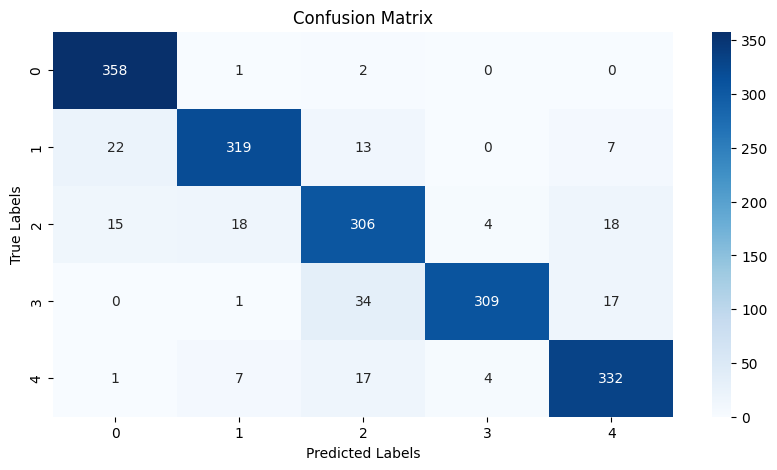

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.95       361
           1       0.92      0.88      0.90       361
           2       0.82      0.85      0.83       361
           3       0.97      0.86      0.91       361
           4       0.89      0.92      0.90       361

    accuracy                           0.90      1805
   macro avg       0.90      0.90      0.90      1805
weighted avg       0.90      0.90      0.90      1805



In [2]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize empty lists to hold the true labels and predictions
true_classes = []
predicted_classes = []

# Loop over the validation data generator
for i in range(len(val_generator)):
    # Get batch data
    x_batch, y_batch = val_generator[i]
    
    # Predict the classes for the current batch
    preds = model.predict(x_batch)
    
    # Get the class labels for the predictions (argmax to get the index of max probability)
    predicted_classes_batch = np.argmax(preds, axis=1)
    
    # Append true labels and predicted labels to the lists
    true_classes.extend(np.argmax(y_batch, axis=1))  # Convert one-hot to class index
    predicted_classes.extend(predicted_classes_batch)

# Convert to numpy arrays
true_classes = np.array(true_classes)
predicted_classes = np.array(predicted_classes)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification Report
class_report = classification_report(true_classes, predicted_classes, target_names=val_generator.class_indices.keys())
print("Classification Report:")
print(class_report)


In [4]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = tf.keras.models.load_model("C:\\Users\\Mubashir\\Desktop\\DIABETIC\\FinalModel\\diabetic_retinopathy_model169_initial_20epochs.h5")

# Class labels
class_labels = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

def predict_diabetic_retinopathy(img_path):
    """Predict the stage of diabetic retinopathy from an image."""
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = tf.keras.applications.densenet.preprocess_input(img_array)
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    confidence = np.max(predictions)

    return f"Prediction: {class_labels[predicted_class]}", f"Confidence: {confidence:.2f}"

# Gradio Interface
interface = gr.Interface(
    fn=predict_diabetic_retinopathy,
    inputs=gr.Image(type="filepath", label="Upload Retina Image"),
    outputs=[
        gr.Text(label="Predicted Stage"),
        gr.Text(label="Confidence Score")
    ],
    title="Diabetic Retinopathy Prediction",
    description="Upload a retina image to predict the stage of diabetic retinopathy."
)

# Launch the interface
interface.launch()


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 56ms/step
